# Load package

In [1]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 
from random import sample

# Load data
## Load data from database

In [10]:
path = '../data/'
conn = sqlite3.connect(path + 'trip_data.db')

In [11]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [12]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [13]:
# find the pickup and dropoff time of next trip
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [14]:
conn.close()

In [15]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,301,1.4,-73.967163,40.760845,-73.950188,40.769550,2013-06-01 00:18:53,2013-06-01 00:36:36
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,1062,3.1,-73.951576,40.770050,-73.990005,40.752110,2013-06-01 01:24:12,2013-06-01 01:30:41
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,389,1.9,-73.972466,40.754360,-73.951447,40.771881,2013-06-02 08:58:59,2013-06-02 09:31:24
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,1943,10.3,-73.978645,40.752251,-73.955963,40.655041,2013-06-02 10:01:14,2013-06-02 10:07:11
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,357,1.1,-73.994240,40.724579,-73.999619,40.733402,2013-06-02 10:12:42,2013-06-02 10:18:23


In [16]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

In [17]:
trip_fare = pd.read_csv(path + 'trip_fare_6.csv')
trip_fare.columns = trip_fare.columns.str.replace(' ','')
trip_fare.loc[:,'pickup_datetime'] = pd.to_datetime(trip_fare['pickup_datetime'])
trip_fare.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013009441,2013013593,VTS,2013-06-01,CSH,5.0,0.5,0.5,0.0,0.0,6.0
1,2013012081,2013019632,VTS,2013-06-01,CRD,14.5,0.5,0.5,1.5,0.0,17.0
2,2013006133,2013029678,VTS,2013-06-01,CSH,9.5,0.5,0.5,0.0,0.0,10.5
3,2013007864,2013007860,VTS,2013-06-01,CRD,8.0,0.5,0.5,1.7,0.0,10.7
4,2013010123,2013010123,VTS,2013-06-01,CSH,19.5,0.5,0.5,0.0,0.0,20.5


In [18]:
sampled_trip = sampled_trip.merge(trip_fare.drop(['vendor_id'], axis=1), on =['medallion','hack_license','pickup_datetime'])
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,301,1.4,-73.967163,...,40.769550,2013-06-01 00:18:53,2013-06-01 00:36:36,CRD,6.5,0.5,0.5,1.5,0.0,9.0
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,1062,3.1,-73.951576,...,40.752110,2013-06-01 01:24:12,2013-06-01 01:30:41,CSH,14.0,0.5,0.5,0.0,0.0,15.0
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,389,1.9,-73.972466,...,40.771881,2013-06-02 08:58:59,2013-06-02 09:31:24,CSH,8.0,0.5,0.5,0.0,0.0,9.0
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,1943,10.3,-73.978645,...,40.655041,2013-06-02 10:01:14,2013-06-02 10:07:11,CSH,34.0,0.0,0.5,0.0,0.0,34.5
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,357,1.1,-73.994240,...,40.733402,2013-06-02 10:12:42,2013-06-02 10:18:23,CRD,6.0,0.0,0.5,2.0,0.0,8.5


In [19]:
# save
sampled_trip.to_csv(path + 'sampled_trip.csv', index=False)
print('Saved sample_trip.csv!')

Saved sample_trip.csv!


## Load sample data

In [20]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'sampled_trip.csv')
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,301,1.4,-73.967163,...,40.769550,2013-06-01 00:18:53,2013-06-01 00:36:36,CRD,6.5,0.5,0.5,1.5,0.0,9.0
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,1062,3.1,-73.951576,...,40.752110,2013-06-01 01:24:12,2013-06-01 01:30:41,CSH,14.0,0.5,0.5,0.0,0.0,15.0
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,389,1.9,-73.972466,...,40.771881,2013-06-02 08:58:59,2013-06-02 09:31:24,CSH,8.0,0.5,0.5,0.0,0.0,9.0
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,1943,10.3,-73.978645,...,40.655041,2013-06-02 10:01:14,2013-06-02 10:07:11,CSH,34.0,0.0,0.5,0.0,0.0,34.5
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,357,1.1,-73.994240,...,40.733402,2013-06-02 10:12:42,2013-06-02 10:18:23,CRD,6.0,0.0,0.5,2.0,0.0,8.5


In [21]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

----

# EDA
## Trip time
- Over 99% trips are within 20 mins 
- Less than 1% trips are less than 1 minute or over 3 hous. For trips longer than 3 hours, the distance travelled does not need that long time. Consider they are mistake record
- Less than 1% trips have `dropoff_time` < `pickup_time` (drop-off time ealier than pick-up time)
- Half of `dropoff_time` - `pickup_time` does not euqal to `trip_time_in_secs`, but over 99% of the difference are within 30 seconds

**Cleaning**
- Calculate `trip_time` = `dropoff_time` - `pickup_time`
- Drop trips that have at least one of the following values:
    - `dropoff_time` < `pickup_time` 
    - Trips that last less than 1 minute
    - Trips that last over 3 hours

In [22]:
N = sampled_trip.shape[0]
n0 = sum((sampled_trip['dropoff_datetime'] <= sampled_trip['pickup_datetime']))
n1 = sum((sampled_trip['dropoff_datetime'] - 
          sampled_trip['pickup_datetime']).dt.total_seconds() != sampled_trip['trip_time_in_secs'])

n2 = sum(abs((sampled_trip['dropoff_datetime'] - 
              sampled_trip['pickup_datetime']).dt.total_seconds() - sampled_trip['trip_time_in_secs'])>30)

n3 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) < pd.Timedelta(minutes=1))
n4 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=20))
n5 = sum((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']) > pd.Timedelta(minutes=180))

print('{n0} ({n0_per:.2f}%) records: drop-off time before pick-up time\n\
{n1} ({n1_per:.2f}%) records: drop-off time - pick-up time != trip_time_in_secs\n\
{n2} ({n2_per:.2f}%) records: the difference > 30s\n\
{n3} ({n3_per:.2f}%) records: trip time less than 1 minutes\n\
{n4} ({n3_per:.2f}%) records: trip time over 20 minutes\n\
{n5} ({n5_per:.2f}%) records: trip time over 180 minutes\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                 n1 = n1, n1_per = n1/N*100,
                                                                 n2 = n2, n2_per = n2/N*100,
                                                                 n3 = n3, n3_per = n3/N*100,
                                                                 n4 = n4, n4_per = n4/N*100,
                                                                 n5 = n5, n5_per = n5/N*100))
print((sampled_trip['dropoff_datetime'] - sampled_trip['pickup_datetime']).describe())

8006 (0.37%) records: drop-off time before pick-up time
941328 (43.39%) records: drop-off time - pick-up time != trip_time_in_secs
21643 (1.00%) records: the difference > 30s
15539 (0.72%) records: trip time less than 1 minutes
361249 (0.72%) records: trip time over 20 minutes
31 (0.00%) records: trip time over 180 minutes
count                   2169628
mean     0 days 00:13:06.502302
std      0 days 00:42:57.656182
min           -4 days +13:01:39
25%             0 days 00:06:20
50%             0 days 00:10:35
75%             0 days 00:16:56
max            11 days 00:39:57
dtype: object


In [23]:
sampled_trip.loc[:,'trip_time'] = (sampled_trip['dropoff_datetime'] - 
                                   sampled_trip['pickup_datetime']) / pd.Timedelta(minutes=1)
sampled_trip.loc[(sampled_trip['trip_time']>180), :]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,pickup_datetime_next,dropoff_datetime_next,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_time
198539,2013002805,2013002802,CMT,1,2013-06-17 09:17:59,2013-06-17 12:54:33,3,650,36.9,0.000000,...,2013-06-17 12:57:40,2013-06-17 13:28:26,CSH,113.5,0.0,0.5,0.00,13.58,127.58,216.566667
325019,2013001323,2013004708,CMT,1,2013-06-01 04:22:00,2013-06-01 12:32:28,1,114,16.5,-73.948212,...,2013-06-01 12:42:41,2013-06-01 12:49:42,CRD,8.5,0.0,0.5,1.00,0.00,10.00,490.466667
367630,2013005341,2013005338,CMT,1,2013-06-02 00:35:18,2013-06-13 00:51:01,3,826,4.0,-74.007370,...,2013-06-02 20:59:16,2013-06-02 21:02:58,CSH,14.0,0.5,0.5,0.00,0.00,15.00,15855.716667
367634,2013005341,2013005338,CMT,1,2013-06-03 02:32:09,2013-06-14 02:46:40,1,747,3.9,-73.981827,...,2013-06-03 21:07:26,2013-06-14 21:47:23,CRD,13.5,0.5,0.5,2.50,0.00,17.00,15854.516667
367635,2013005341,2013005338,CMT,1,2013-06-03 21:07:26,2013-06-14 21:47:23,2,2271,7.5,-73.991280,...,2013-06-04 20:50:39,2013-06-15 21:08:58,CRD,29.5,0.5,0.5,4.00,0.00,34.50,15879.950000
367636,2013005341,2013005338,CMT,1,2013-06-04 20:50:39,2013-06-15 21:08:58,1,968,4.0,-74.005287,...,2013-06-04 22:24:43,2013-06-15 22:48:12,CRD,15.0,0.5,0.5,3.20,0.00,19.20,15858.316667
367637,2013005341,2013005338,CMT,1,2013-06-04 22:24:43,2013-06-15 22:48:12,1,1279,3.8,-73.971680,...,2013-06-05 21:04:01,2013-06-16 21:16:36,CRD,17.0,0.5,0.5,1.00,0.00,19.00,15863.483333
367638,2013005341,2013005338,CMT,1,2013-06-05 21:04:01,2013-06-16 21:16:36,3,621,2.8,-73.964546,...,2013-06-06 02:29:33,2013-06-17 02:39:30,CSH,11.0,0.5,0.5,0.00,0.00,12.00,15852.583333
367639,2013005341,2013005338,CMT,1,2013-06-06 02:29:33,2013-06-17 02:39:30,2,463,2.0,-73.998207,...,2013-06-07 00:02:27,2013-06-07 00:18:54,CSH,8.5,0.5,0.5,0.00,0.00,9.50,15849.950000
367657,2013005341,2013005338,CMT,1,2013-06-07 22:15:35,2013-06-18 22:29:40,1,706,1.7,-73.982285,...,2013-06-07 22:22:02,2013-06-07 22:27:00,CRD,9.5,0.5,0.5,1.00,0.00,11.50,15854.083333


In [24]:
index_time = (sampled_trip['trip_time']>1) & (sampled_trip['trip_time']<=180)

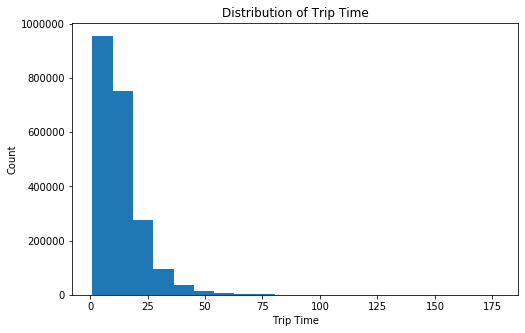

In [25]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_time, 'trip_time'].hist(bins=20, grid=False);
plt.xlabel('Trip Time');
plt.ylabel('Count');
plt.title('Distribution of Trip Time');

## Trip distance
- Over 75% trips are within 4 miles
- Less than 1% trips are longer than 30 miles
- Over 75% trips have average speed of about 15 mph

**Cleaning**
- Calculate `ave_speed` = `trip_distance` / `trip_time` * 60
- Drop trips that have at least one of the following values:
    - Speed over 50 mph ([highest speed limit in New York](https://www1.nyc.gov/html/dot/downloads/pdf/current-pre-vision-zero-speed-limit-maps.pdf))
    - Trips that longer than 30 miles ([The Manhattan Island](https://www.nycgo.com/plan-your-trip/basic-information/) is roughly 13.4 miles long and about 2.3 miles wide)

In [26]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['trip_distance']<10), 'trip_distance'])
n1 = len(sampled_trip.loc[(sampled_trip['trip_distance']>30), 'trip_distance'])
n2 = len(sampled_trip.loc[(sampled_trip['trip_distance']<=0), 'trip_distance'])
print('{n0} ({n0_per:.2f}%) records: trip distance within 10 mile\n\
{n1} ({n1_per:.2f}%) records: trip distance are over 30 mile\n\
{n2} ({n2_per:.2f}%) records: trip distance <= 0 mile\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                             n1 = n1, n1_per = n1/N*100,
                                                             n2 = n2, n2_per = n2/N*100))
print(sampled_trip['trip_distance'].describe())
print('=========================================================\nAverage speed')
print((sampled_trip['trip_distance'] / sampled_trip['trip_time'] * 60).describe())

2062702 (95.07%) records: trip distance within 10 mile
437 (0.02%) records: trip distance are over 30 mile
10923 (0.50%) records: trip distance <= 0 mile
count    2.169628e+06
mean     2.930573e+00
std      3.373242e+00
min      0.000000e+00
25%      1.080000e+00
50%      1.800000e+00
75%      3.300000e+00
max      9.707000e+01
Name: trip_distance, dtype: float64
Average speed
count    2.165831e+06
mean              inf
std               NaN
min     -4.590000e+03
25%      8.372093e+00
50%      1.155963e+01
75%      1.576037e+01
max               inf
dtype: float64


In [27]:
index_distance = (((sampled_trip['trip_distance']/sampled_trip['trip_time']*60)<50) & 
                  (sampled_trip['trip_distance']<30) & 
                  (sampled_trip['trip_distance']>0))

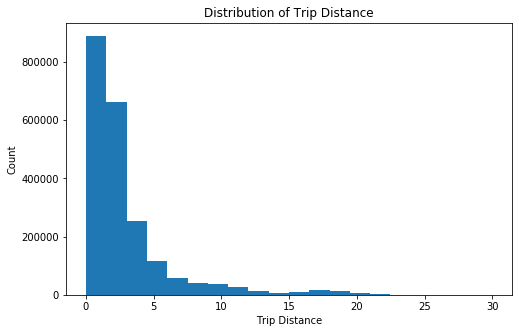

In [28]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_distance, 'trip_distance'].hist(bins=20, grid=False);
plt.xlabel('Trip Distance');
plt.ylabel('Count');
plt.title('Distribution of Trip Distance');

## Trip fare
- Over 99% trips have fare more than \\$2.5 and less than \\$150
- 82% trips have fare less then \\$20

**Cleaning**
- Drop trips that have trip fare over \\$150 (\\$2.5 * 60 miles)

In [29]:
N = sampled_trip.shape[0]
n0 = len(sampled_trip.loc[(sampled_trip['total_amount']<=2.5), 'total_amount'])
n1 = len(sampled_trip.loc[(sampled_trip['total_amount']<=20), 'total_amount'])
n2 = len(sampled_trip.loc[(sampled_trip['total_amount']<150), 'total_amount'])
print('{n0} ({n0_per:.2f}%) records: trip fare < $2.5\n\
{n1} ({n1_per:.2f}%) records: trip fare < $20\n\
{n2} ({n2_per:.2f}%) records: trip fare < $150\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                                  n1 = n1, n1_per = n1/N*100,
                                                                  n2 = n2, n2_per = n2/N*100))
print(sampled_trip['total_amount'].describe())

3 (0.00%) records: trip fare < $2.5
1790503 (82.53%) records: trip fare < $20
2169253 (99.98%) records: trip fare < $150
count    2.169628e+06
mean     1.500379e+01
std      1.210452e+01
min      2.500000e+00
25%      8.000000e+00
50%      1.140000e+01
75%      1.700000e+01
max      5.655000e+02
Name: total_amount, dtype: float64


In [30]:
index_fare = sampled_trip['total_amount']<150

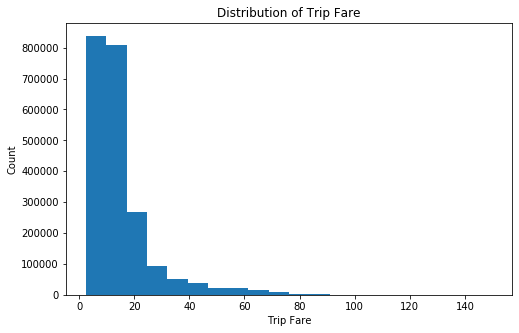

In [31]:
plt.figure(figsize=(8,5))
sampled_trip.loc[index_fare, 'total_amount'].hist(bins=20, grid=False);
plt.xlabel('Trip Fare');
plt.ylabel('Count');
plt.title('Distribution of Trip Fare');

# Pick-up and drop-off location
- Over 98% trips' pick-up and drop-off locations are within NYC

**Cleaning**
- Drop trips with pick-up or drop-off location outside of NYC

In [32]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

In [33]:
# download map here: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-Map/5fzm-kpwv
nyc_map = pd.read_csv(path + '../data/Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
nyc_map['geometry'] = nyc_map['the_geom'].apply(wkt.loads)
nyc_map = gpd.GeoDataFrame(nyc_map, crs='EPSG:4326').drop('the_geom', axis=1)

# download map here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
# nyc_map = gpd.read_file(path + '../Neighborhood Tabulation Areas (NTA).geojson')

# download map here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
# nyc_map = gpd.read_file(path + '../ZIP_CODE_040114/ZIP_CODE_040114.shp')

# download map here: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
# nyc_map = gpd.read_file(path +'../Borough_Boundaries/geo_export_573e53b9-f38f-46eb-be8d-0f07d0d0e9d1.shp')
nyc_map.head()

,MODZCTA,label,ZCTA,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ..."
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ..."
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ..."
3,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
4,10005,10005,"10005, 10271",8831,"MULTIPOLYGON (((-74.00783 40.70309, -74.00786 ..."


In [34]:
# drop gps records (roughly) outside of nyc 
nyc_loc = [-74.25,-73.75, 40.45, 40.95]
index_location = (sampled_trip['pickup_longitude'] > nyc_loc[0]) &   \
                    (sampled_trip['pickup_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['pickup_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['pickup_latitude'] < nyc_loc[3]) & \
                    (sampled_trip['dropoff_longitude'] > nyc_loc[0]) & \
                    (sampled_trip['dropoff_longitude'] < nyc_loc[1]) & \
                    (sampled_trip['dropoff_latitude'] > nyc_loc[2]) & \
                    (sampled_trip['dropoff_latitude'] < nyc_loc[3])


N = sampled_trip.shape[0]
n0 = sum(index_location)
print('{n0} ({n0_per:.2f}%) are roughly in NYC'.format(n0=n0, n0_per=n0/N*100))

2127559 (98.06%) are roughly in NYC


In [35]:
# location_index = sampled_trip.index.tolist()
features = ['hack_license','trip_distance',
            'pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude']

sample_n = 5000
sample_index = sample(index_location[index_location==True].index.tolist(), sample_n)

# convert the first pickup location to geometric form
pickup_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                   geometry = gpd.points_from_xy(sampled_trip.loc[sample_index, 'pickup_longitude'],
                                                                 sampled_trip.loc[sample_index, 'pickup_latitude']))

# convert the last dropoff location to geometric form
dropoff_location = gpd.GeoDataFrame(sampled_trip.loc[sample_index, features], 
                                    geometry = gpd.points_from_xy(sampled_trip.loc[sample_index, 'dropoff_longitude'],
                                                                  sampled_trip.loc[sample_index, 'dropoff_latitude']))

pickup_location.head()

,hack_license,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geometry
1088536,2013016008,1.55,-74.001282,40.741379,-74.004257,40.756935,POINT (-74.00128 40.74138)
1203797,2013017997,3.37,-73.962219,40.809982,-73.957924,40.774529,POINT (-73.96222 40.80998)
272850,2013003918,3.50,-73.914886,40.753777,-73.966034,40.765377,POINT (-73.91489 40.75378)
1266080,2013019263,12.56,-73.969383,40.763657,-74.028870,40.616894,POINT (-73.96938 40.76366)
119172,2013001589,0.40,-73.992950,40.758633,-74.000465,40.761433,POINT (-73.99295 40.75863)


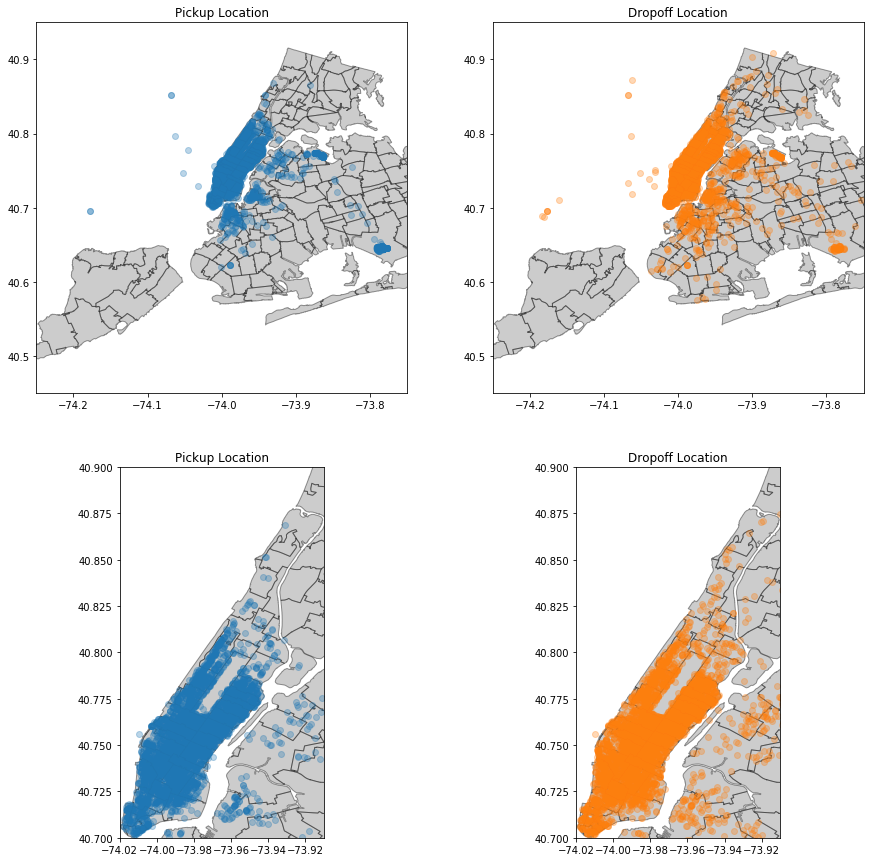

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
# add mapfile to axes
nyc_map.plot(ax=ax[0,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[0,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,0].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,0].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[0,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[0,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[0,1].set_xlim(nyc_loc[0], nyc_loc[1]);
ax[0,1].set_ylim(nyc_loc[2], nyc_loc[3]);
ax[0,1].set_title('Dropoff Location');

nyc_map.plot(ax=ax[1,0], alpha=0.4, edgecolor='k', color='grey');
pickup_location.plot(ax=ax[1,0], color='tab:blue', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,0].set_xlim(-74.02,-73.91);
ax[1,0].set_ylim( 40.7,40.9);
ax[1,0].set_title('Pickup Location');

# add mapfile to axes
nyc_map.plot(ax=ax[1,1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location.plot(ax=ax[1,1], color='tab:orange', alpha=0.3);
# set latitiude and longitude boundaries for map display
ax[1,1].set_xlim(-74.02,-73.91);
ax[1,1].set_ylim( 40.7,40.9);
ax[1,1].set_title('Dropoff Location');

----
## Drop outliers

In [48]:
# drop outliers
N = sampled_trip.shape[0]
n1 = sum(~(index_time & index_distance & index_fare & index_location))
print('drop {:.2f} % of data'.format(n1/N*100))
sampled_trip = sampled_trip.loc[(index_time & index_distance & index_fare & index_location), :]\
                            .drop('trip_time_in_secs', axis=1) \
                            .sort_values(['hack_license', 'pickup_datetime', 'dropoff_datetime'])
# recalculate delta
sampled_trip.loc[:, 'pickup_datetime_next'] = sampled_trip.groupby(['hack_license'])['pickup_datetime'].shift(-1)
sampled_trip.loc[:, 'dropoff_datetime_next'] = sampled_trip.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
sampled_trip.loc[:, 'delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)
sampled_trip.head()

drop 2.95 % of data


,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,tolls_amount,total_amount,trip_time,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,delta
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,1.4,-73.967163,40.760845,...,0.0,9.0,5.033333,00:15:00,00:15:00,2013-06-01,2013-06-01,0,0,0.095000
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,3.1,-73.951576,40.770050,...,0.0,15.0,17.716667,00:30:00,00:15:00,2013-06-01,2013-06-01,0,0,0.793333
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,1.9,-73.972466,40.754360,...,0.0,9.0,6.483333,01:30:00,01:30:00,2013-06-01,2013-06-01,0,0,31.471667
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,10.3,-73.978645,40.752251,...,0.0,34.5,32.416667,09:30:00,09:00:00,2013-06-02,2013-06-02,0,0,0.497222
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,1.1,-73.994240,40.724579,...,0.0,8.5,5.950000,10:00:00,10:00:00,2013-06-02,2013-06-02,0,0,0.091944


- k=3, 41 (0.002%) active time > 24h
- k=4, 79 (0.004%) active time > 24h
- k=5, 127 (0.006%) active time > 24h

In [49]:
k = 5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [50]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,delta,last_dropoff,first_pickup
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,1.4,-73.967163,40.760845,...,5.033333,00:15:00,00:15:00,2013-06-01,2013-06-01,0,0,0.095000,0,0.0
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,3.1,-73.951576,40.770050,...,17.716667,00:30:00,00:15:00,2013-06-01,2013-06-01,0,0,0.793333,0,0.0
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,1.9,-73.972466,40.754360,...,6.483333,01:30:00,01:30:00,2013-06-01,2013-06-01,0,0,31.471667,1,0.0
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,10.3,-73.978645,40.752251,...,32.416667,09:30:00,09:00:00,2013-06-02,2013-06-02,0,0,0.497222,0,1.0
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,1.1,-73.994240,40.724579,...,5.950000,10:00:00,10:00:00,2013-06-02,2013-06-02,0,0,0.091944,0,0.0


In [51]:
## Extract hour and day
sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.time
sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.time
# sampled_trip['dropoff_time'] = sampled_trip.dropoff_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.dropoff_datetime.dt.round('15min').dt.minute / 60
# sampled_trip['pickup_time'] = sampled_trip.pickup_datetime.dt.round('15min').dt.hour + \
#                                 sampled_trip.pickup_datetime.dt.round('15min').dt.minute / 60
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [52]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,delta,last_dropoff,first_pickup
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,1.4,-73.967163,40.760845,...,5.033333,00:15:00,00:15:00,2013-06-01,2013-06-01,0,0,0.095000,0,0.0
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,3.1,-73.951576,40.770050,...,17.716667,00:30:00,00:15:00,2013-06-01,2013-06-01,0,0,0.793333,0,0.0
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,1.9,-73.972466,40.754360,...,6.483333,01:30:00,01:30:00,2013-06-01,2013-06-01,0,0,31.471667,1,0.0
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,10.3,-73.978645,40.752251,...,32.416667,09:30:00,09:00:00,2013-06-02,2013-06-02,0,0,0.497222,0,1.0
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,1.1,-73.994240,40.724579,...,5.950000,10:00:00,10:00:00,2013-06-02,2013-06-02,0,0,0.091944,0,0.0


## First pick-up and last drop-off distribution
- Two peaks of pick-up time: 6:00 am, 5:00 pm
- Two peaks of drop-off time: 1:00 am, 4:00 pm
- The pick-up peak on weekend morning appears later: 7:00 am
- The drop-off peak on weekend midnight appears later: 4:00 am

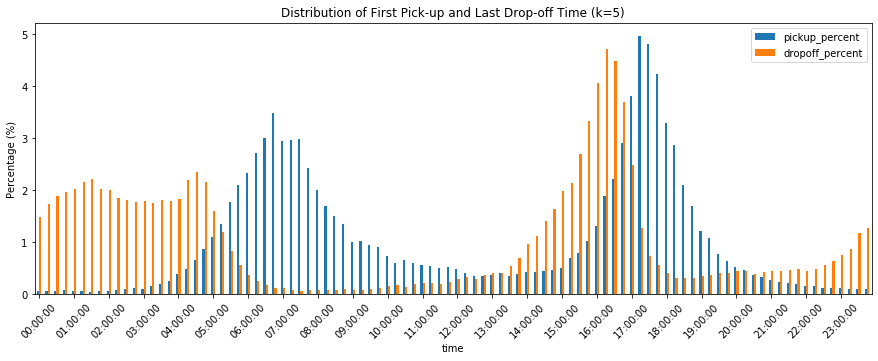

In [53]:
## Compute percentage
ticks = sorted(sampled_trip['pickup_time'].unique())

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_time', 'pickup_weekday'])['pickup_time'].count()
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_time':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_time':'time',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_time', 'dropoff_weekday'])['dropoff_time'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_time':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_time':'time',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
# pick_drop_per_all = pick_drop_per.groupby(['time'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_all = pick_drop_per.groupby(['time'])['pickup_percent','dropoff_percent'].mean()
pick_drop_per_all[['pickup_percent','dropoff_percent']] /= pick_drop_per_all[['pickup_percent','dropoff_percent']].sum() / 100

fig,ax = plt.subplots(figsize = (15,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('time');
ax.set_ylabel('Percentage (%)');
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
ax.set_xticks(xticks[::4]);
ax.set_xticklabels(xticklabels[::4], rotation=45);
ax.set_title('Distribution of First Pick-up and Last Drop-off Time (k={})'.format(k));
ax.legend();
# fig.savefig(path + '../img/pick_drop_time(k_{}).png'.format(k));

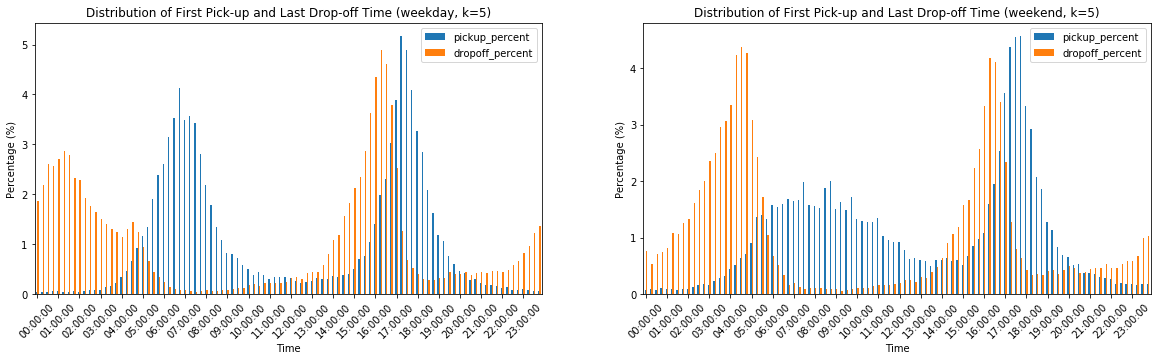

In [54]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
# pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])['pickup_percent','dropoff_percent'].mean().\
#                                 reset_index().set_index('time')
pick_drop_per_wk = pick_drop_per.groupby(['time','weekday'])['pickup_percent','dropoff_percent'].mean()
pick_drop_per_wk[['pickup_percent','dropoff_percent']] /= pick_drop_per_wk[['pickup_percent',
                                                                            'dropoff_percent']].groupby(level=1).sum() / 100
pick_drop_per_wk = pick_drop_per_wk.reset_index().set_index('time')

fig,ax = plt.subplots(1,2,figsize = (20,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
xticks = ax[0].get_xticks()
xticklabels = ax[0].get_xticklabels()
ax[0].set_xticks(xticks[::4]);
ax[0].set_xticklabels(xticklabels[::4], rotation=45);
ax[0].set_xlabel('Time');
ax[0].set_ylabel('Percentage (%)');
ax[0].set_title('Distribution of First Pick-up and Last Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

xticks = ax[1].get_xticks()
xticklabels = ax[1].get_xticklabels()
ax[1].set_xticks(xticks[::4]);
ax[1].set_xticklabels(xticklabels[::4], rotation=45);
ax[1].set_xlabel('Time');
ax[1].set_ylabel('Percentage (%)');
ax[1].set_title('Distribution of First Pick-up and Last Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();
# fig.savefig(path + '../img/pick_drop_time_wk(k_{}).png'.format(k));

# Active time
- Over 75% shifts are within 10 hours; most of the shift are 8 to 10 hours
- Less than 1% shifts are over 24 hours.This depends on the choice of threshold `k`
- Less than 1% shifts are less than 1 hours. Some drivers would work a few trips during rest time

**Cleaning**
- Drop data that have active time less than 1 hour or over 24 hours

In [55]:
# compute active time 
# Active time = end time of the shift - start time of the shift
active_time = sampled_trip.loc[sampled_trip['last_dropoff'] == 1,
                               ['hack_license', 'dropoff_datetime','pickup_datetime_next']].\
                        rename(columns={'pickup_datetime_next':'start_datetime'}).\
                        sort_values(['hack_license','start_datetime'])

active_time['end_datetime'] = active_time.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
active_time['active_hour'] = (active_time['end_datetime'] - active_time['start_datetime']) / pd.Timedelta(hours=1)
active_time = active_time.drop(['dropoff_datetime'], axis=1).dropna()
active_time.head()

,hack_license,start_datetime,end_datetime,active_hour
2,2013000009,2013-06-02 08:58:59,2013-06-02 21:35:10,12.603056
23,2013000009,2013-06-04 07:47:38,2013-06-04 21:45:29,13.964167
50,2013000009,2013-06-06 07:50:46,2013-06-06 12:43:57,4.886389
59,2013000009,2013-06-06 18:29:15,2013-06-07 01:04:59,6.595556
77,2013000009,2013-06-07 19:16:53,2013-06-08 01:03:40,5.779722


In [56]:
# drop incorrect record 
N = sampled_trip.shape[0]
n0 = active_time[(active_time.active_hour<1)].shape[0]
n1 = active_time[(active_time.active_hour>=24)].shape[0]
print('{n0} ({n0_per:.3f}%) records: active time < 1 hour\n\
{n1} ({n1_per:.3f}%) records: active time > 24 hours\n\
========================================================='.format(n0 = n0, n0_per = n0/N*100,
                                                             n1 = n1, n1_per = n1/N*100))
print(active_time.active_hour.describe())

1110 (0.053%) records: active time < 1 hour
187 (0.009%) records: active time > 24 hours
count    89883.000000
mean         8.786513
std          3.178809
min          0.017778
25%          7.350000
50%          8.916667
75%         10.283333
max        109.322778
Name: active_hour, dtype: float64


In [57]:
index_active_hour = (active_time.active_hour>1) & (active_time.active_hour<24)

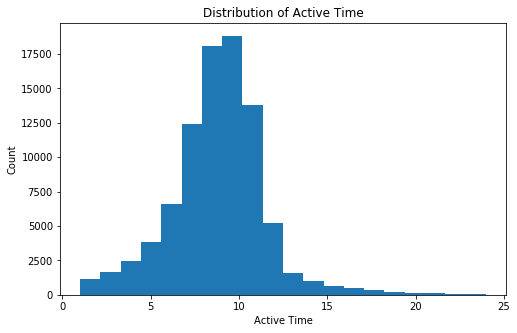

In [58]:
plt.figure(figsize=(8,5))
active_time.loc[index_active_hour, 'active_hour'].hist(bins=20, grid=False);
plt.xlabel('Active Time');
plt.ylabel('Count');
plt.title('Distribution of Active Time');
# fig.savefig(path + '../img/active_time(k_{}).png'.format(k));

In [59]:
# save
sampled_trip.to_csv(path + 'sampled_trip_cleaned.csv', index=False)
print('Saved sampled_trip_cleaned.csv!')

Saved sampled_trip_cleaned.csv!


## Summary stat of actual data

## ===== 1 pickups


In [246]:
sum_stat_data = first_last_trip.loc[~first_last_trip['_PU_shift'].isna()]

sum_stat_data.rename(columns={"_PU_shift": "shift", "pickup_weekday": "weekday", 'pickup_time': 'time_minute'}, inplace=True)
sum_stat_data['time_minute_rep'] = [time.hour*60 + time.minute for time in sum_stat_data['time_minute']]#.apply(lambda x: x.time())]

## handle hours before the midnight of Shift A PU on weekday
sum_stat_data.loc[(sum_stat_data['shift'] == 'A') &
                  (sum_stat_data['weekday'] == 1), 'time_minute_rep'] = [t-(24*60) if t>(23*60+30) else t \
                                            for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'A') &
                                                                       (sum_stat_data['weekday'] == 1),
                                                                       'time_minute_rep']]
## handle hours before the midnight of Shift A PU on weekday
sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                  (sum_stat_data['weekday'] == 0), 'time_minute_rep'] = [t+(24*60) if t<=(2*60) else t \
                                            for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                       (sum_stat_data['weekday'] == 0), 
                                                                       'time_minute_rep']]



//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [247]:
PU_mean = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
PU_mean.rename('Mean Start Time', inplace=True)
print('mean PU')
print(PU_mean)

PU_std = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
PU_std.rename('STD Start Time', inplace=True)
print('std PU')
print(PU_std)



mean PU
weekday  shift
0        A         8:32
         B        17:51
1        A         6:58
         B        17:17
Name: Mean Start Time, dtype: object
std PU
weekday  shift
0        A        2:35
         B        1:53
1        A        1:42
         B        1:48
Name: STD Start Time, dtype: object


## ===== 2 dropoff

In [248]:
sum_stat_data = first_last_trip.loc[~first_last_trip['_DO_shift'].isna()]

sum_stat_data.rename(columns={"_DO_shift": "shift", "pickup_weekday": "weekday", 'pickup_time': 'time_minute'}, inplace=True)
sum_stat_data['time_minute_rep'] = [time.hour*60 + time.minute for time in sum_stat_data['time_minute']]#.apply(lambda x: x.time())]

sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                         (sum_stat_data['weekday'] == 1), 'time_minute_rep'] = [t-(24*60) if t>(20*60+30) else t \
                                                                                              for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                                                                                 (sum_stat_data['weekday'] == 1),
                                                                                                                                 'time_minute_rep']]
                                                                                                                                 
 
                                                                                                                                 
sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                         (sum_stat_data['weekday'] == 0), 'time_minute_rep'] = [t-(24*60) if t>(22*60) else t \
                                                                                              for t in sum_stat_data.loc[(sum_stat_data['shift'] == 'B') &
                                                                                                                                 (sum_stat_data['weekday'] == 0), 
                                                                                                                                 'time_minute_rep']]


DO_mean = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
DO_mean.rename('Mean End Time', inplace=True)
print('mean DO')
print(mean_stat)

DO_std = sum_stat_data.groupby(['weekday', 'shift'])['time_minute_rep']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
DO_std.rename('STD End Time', inplace=True)
print('std DO')
print(std_stat)



mean DO
weekday  shift
0        A         16:5
         B         3:22
1        A        15:22
         B         1:43
Name: time_minute_rep, dtype: object
std DO
weekday  shift
0        A         2:8
         B        2:45
1        A        1:53
         B        2:55
Name: time_minute_rep, dtype: object


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [255]:
merge_stat = PU_mean.to_frame().join(DO_mean).join(PU_std).join(DO_std)
print(merge_stat)
print(merge_stat.to_latex())

              Mean Start Time Mean End Time STD Start Time STD End Time
weekday shift                                                          
0       A                8:32          16:5           2:35          2:8
        B               17:51          3:22           1:53         2:45
1       A                6:58         15:22           1:42         1:53
        B               17:17          1:43           1:48         2:55
\begin{tabular}{llllll}
\toprule
  &   & Mean Start Time & Mean End Time & STD Start Time & STD End Time \\
weekday & shift &                 &               &                &              \\
\midrule
0 & A &            8:32 &          16:5 &           2:35 &          2:8 \\
  & B &           17:51 &          3:22 &           1:53 &         2:45 \\
1 & A &            6:58 &         15:22 &           1:42 &         1:53 \\
  & B &           17:17 &          1:43 &           1:48 &         2:55 \\
\bottomrule
\end{tabular}



----

# Active Time Estimation

* active time = last drop-off time - first pick-up time
* There are 2 shifts in a day. We define shift A and shift B. Early pickups are associated with later dropoffs and later pickups are associated with early dropoffs.

  ![Caption for the picture.](../fig/shift_range.png)
  
* The decision on the time ranges are based on the distributions presented above.
* There are about the same proportion of drivers in each shift.
* To simulate an active time of a driver, we
    1. randomly pick shift with 1/2 chance being in shift A (equally proportionated)
    2. randomly pick the first PU time from all PU times in the chosen shift
    3. randomly pick the last DO time from all DO times in the chosen shift (must be later than the chosen first PU time)

In [2]:
path = '../data/'
sampled_trip = pd.read_csv(path + 'sampled_trip_cleaned.csv')
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,delta,last_dropoff,first_pickup,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000001,2013000001,VTS,1,2013-06-24 18:55:00,2013-06-24 19:01:00,1,0.97,-73.992531,40.724052,...,6.0,0.183333,0,0.0,19:00:00,19:00:00,2013-06-24,2013-06-24,1,1
1,2013000001,2013000001,VTS,1,2013-06-24 19:12:00,2013-06-24 19:30:00,1,3.04,-73.982498,40.745617,...,18.0,0.250000,0,0.0,19:30:00,19:15:00,2013-06-24,2013-06-24,1,1
2,2013000001,2013000001,VTS,1,2013-06-24 19:45:00,2013-06-24 20:10:00,2,4.17,-73.981850,40.768753,...,25.0,0.116667,0,0.0,20:15:00,19:45:00,2013-06-24,2013-06-24,1,1
3,2013000001,2013000001,VTS,1,2013-06-24 20:17:00,2013-06-24 20:28:00,1,2.35,-73.988129,40.738098,...,11.0,0.033333,0,0.0,20:30:00,20:15:00,2013-06-24,2013-06-24,1,1
4,2013000001,2013000001,VTS,1,2013-06-24 20:30:00,2013-06-24 20:35:00,1,1.24,-73.961098,40.760826,...,5.0,0.033333,0,0.0,20:30:00,20:30:00,2013-06-24,2013-06-24,1,1


In [3]:
sampled_trip.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime_next',
       'dropoff_datetime_next', 'payment_type', 'fare_amount', 'surcharge',
       'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_time',
       'delta', 'last_dropoff', 'first_pickup', 'dropoff_time', 'pickup_time',
       'dropoff_day', 'pickup_day', 'pickup_weekday', 'dropoff_weekday'],
      dtype='object')

In [4]:
# convert time columns from string to datetime
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])

There is a caveat in the current code. It is possible 

In [102]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else: ## weekend
        if pickup:
            if (time > datetime.time(2, 0)) & (time <= datetime.time(14, 0)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(10, 0)) & (time <= datetime.time(22, 0)):
                return 'A'
            else:
                return 'B'        
        return None
    
def sample_start_end_time(first_last_trip_df, shift_prop, weekday_code):
    random_shift = np.random.choice(['A', 'B'], size=1, 
                                    p = shift_prop.loc[(shift_prop['pickup_weekday'] == weekday_code)][0].tolist())[0]
    # travel_time = datetime.timedelta(minutes=10)
#     print("random_shift: {}".format(random_shift))
    sampled_PU_time = first_last_trip_df.loc[(first_last_trip_df['_PU_shift'] == random_shift) &
                                            (first_last_trip_df['first_pickup'] == 1)]['PU_time'].sample().values[0]

    if random_shift == 'A':
        try:
            if sampled_PU_time >= datetime.time(20,30):
                sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
            else:
                sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
#         print("-", sampled_DO_time)#
        except:
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None, None
    else: #shift B dropoff
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                ((first_last_trip_df['DO_time'] > sampled_PU_time) |
                                                 (first_last_trip_df['DO_time'] <= datetime.time(8,30)))  &
                                                    (first_last_trip_df['last_dropoff'] == 1)]['DO_time'].sample().values[0]
        except:
            
            print(random_shift)
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time) &
                                                    (first_last_trip_df['last_dropoff'] == 1)].shape)
            return None, None
            #         print("-", sampled_DO_time) #.sample().values[0])
#     print("--Sampled PU time>> {}".format(sampled_PU_time))
#     print("--Sampled DO time>> {}".format(sampled_DO_time))
    
    return sampled_PU_time, sampled_DO_time, random_shift



In [103]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,trip_time,dropoff_time,pickup_time,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday,delta,last_dropoff,first_pickup
0,2013000009,2013000009,CMT,1,2013-06-01 00:08:09,2013-06-01 00:13:11,1,1.4,-73.967163,40.760845,...,5.033333,00:15:00,00:15:00,2013-06-01,2013-06-01,0,0,0.095000,0,0.0
1,2013000009,2013000009,CMT,1,2013-06-01 00:18:53,2013-06-01 00:36:36,1,3.1,-73.951576,40.770050,...,17.716667,00:30:00,00:15:00,2013-06-01,2013-06-01,0,0,0.793333,0,0.0
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,1.9,-73.972466,40.754360,...,6.483333,01:30:00,01:30:00,2013-06-01,2013-06-01,0,0,31.471667,1,0.0
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,10.3,-73.978645,40.752251,...,32.416667,09:30:00,09:00:00,2013-06-02,2013-06-02,0,0,0.497222,0,1.0
4,2013000009,2013000009,CMT,1,2013-06-02 10:01:14,2013-06-02 10:07:11,1,1.1,-73.994240,40.724579,...,5.950000,10:00:00,10:00:00,2013-06-02,2013-06-02,0,0,0.091944,0,0.0


In [104]:
first_last_trip = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) |
                                     (sampled_trip['last_dropoff'] == 1)]

first_last_trip.loc[:,'PU_time'] = first_last_trip['pickup_datetime'].apply(lambda x: x.time())
first_last_trip.loc[:,'DO_time'] = first_last_trip['dropoff_datetime'].apply(lambda x: x.time())


## determine shift for weekdays
first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==1) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

## determine shift for weekends
first_last_trip.loc[(first_last_trip['pickup_weekday']==0) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=True))
first_last_trip.loc[(first_last_trip['dropoff_weekday']==0) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=False, pickup=False))

## statistics summary of start and end times

In [105]:
proportion_table = first_last_trip.loc[first_last_trip['first_pickup'] == 1].groupby(['pickup_weekday', '_PU_shift']).size()\
                .groupby(['pickup_weekday']).apply(lambda x: x/x.sum()).reset_index()
proportion_table

,pickup_weekday,_PU_shift,0
0,0,A,0.497203
1,0,B,0.502797
2,1,A,0.493654
3,1,B,0.506346


## Simulate weekend active hours

In [106]:
def find_time_diff(original_do_time, original_pu_time):
    
    pu_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_pu_time)
    if original_do_time < original_pu_time:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,2), original_do_time)
    else:
        do_time = datetime.datetime.combine(datetime.datetime(2020, 1,1), original_do_time)
        
#     print(pu_time)
#     print(do_time)
    return (do_time - pu_time).total_seconds() / 3600
#     datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), d_list[0]) - datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), p_list[0])

In [107]:
first_last_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,pickup_day,pickup_weekday,dropoff_weekday,delta,last_dropoff,first_pickup,PU_time,DO_time,_PU_shift,_DO_shift
2,2013000009,2013000009,CMT,1,2013-06-01 01:24:12,2013-06-01 01:30:41,1,1.9,-73.972466,40.754360,...,2013-06-01,0,0,31.471667,1,0.0,01:24:12,01:30:41,NaN,B
3,2013000009,2013000009,CMT,1,2013-06-02 08:58:59,2013-06-02 09:31:24,1,10.3,-73.978645,40.752251,...,2013-06-02,0,0,0.497222,0,1.0,08:58:59,09:31:24,A,NaN
23,2013000009,2013000009,CMT,1,2013-06-02 21:29:56,2013-06-02 21:35:10,2,0.5,-73.989998,40.775471,...,2013-06-02,0,0,34.207778,1,0.0,21:29:56,21:35:10,NaN,A
24,2013000009,2013000009,CMT,1,2013-06-04 07:47:38,2013-06-04 07:58:05,1,1.6,-73.939224,40.805016,...,2013-06-04,1,1,0.418889,0,1.0,07:47:38,07:58:05,A,NaN
50,2013000009,2013000009,CMT,1,2013-06-04 21:32:02,2013-06-04 21:45:29,1,2.3,-73.944847,40.787308,...,2013-06-04,1,1,34.088056,1,0.0,21:32:02,21:45:29,NaN,B


In [108]:
p_list = []
d_list = []
weekday_list = []
shift = []
# active_time = {'weekday': [], 'weekend': []}
for t in range(1000):
    pu,do, sh = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 1],
                                 proportion_table, weekday_code=1)
#     p_list.append(pu)
#     d_list.append(do)
    p_list.append(pu)
    d_list.append(do)
    weekday_list.append(1)
    shift.append(sh)
    
    pu,do, sh = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
                                  proportion_table, weekday_code=0)
    
    p_list.append(pu)
    d_list.append(do)
    weekday_list.append(0)
    shift.append(sh)
    
    
#     weekday_time = pd.DataFrame({'weekday': 1, 'start': })
#     try:
#         active_time['weekday'].append(find_time_diff(do, pu))
#     except:
#         print('error in sampling (weekday)')
        
#     pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 0],
#                                  proportion_table, weekday_code=0)
    
#     try:
#         active_time['weekend'].append(find_time_diff(do, pu))
#     except:
#         print('error in sampling (weekend)')


In [188]:
simlated_working_time = pd.DataFrame({'weekday': weekday_list, 'start_time': p_list, 'end_time': d_list, 'shift': shift})
simlated_working_time['end_time'] = [datetime.datetime.combine(datetime.datetime(2020, 1,1), end_t) \
                                     if end_t > t else datetime.datetime.combine(datetime.datetime(2020, 1,2), end_t)\
                                       for t, end_t in zip(simlated_working_time['start_time'], simlated_working_time['end_time'])]
simlated_working_time['start_time'] = [datetime.datetime.combine(datetime.datetime(2020, 1,1), t) \
                                       for t in simlated_working_time['start_time']]


In [189]:
simlated_working_time['active_time'] = (simlated_working_time['end_time'] - simlated_working_time['start_time'])/pd.Timedelta(hours=1)
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time
0,1,2020-01-01 17:56:00,2020-01-01 20:53:33,B,2.959167
1,0,2020-01-01 21:20:00,2020-01-02 04:41:00,B,7.350000
2,1,2020-01-01 07:20:00,2020-01-01 16:07:52,A,8.797778
3,0,2020-01-01 18:39:00,2020-01-02 03:20:00,B,8.683333
4,1,2020-01-01 14:18:00,2020-01-02 02:35:00,B,12.283333


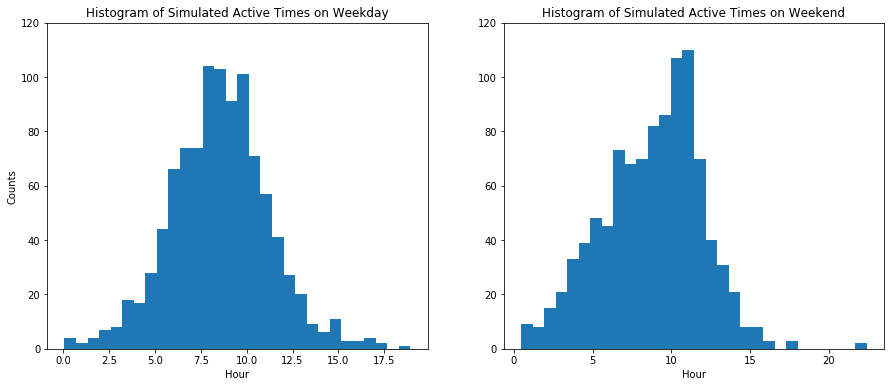

In [111]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(simlated_working_time.loc[simlated_working_time['weekday'] == 1]['active_time'], bins=30)
ax[0].set_title('Histogram of Simulated Active Times on Weekday');
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Counts');
ax[0].set_ylim(0,120)
ax[1].hist(simlated_working_time.loc[simlated_working_time['weekday'] == 0]['active_time'], bins=30)
ax[1].set_title('Histogram of Simulated Active Times on Weekend');
ax[1].set_xlabel('Hour');
ax[1].set_ylim(0,120)
plt.savefig('../fig/simulated_active_times.png')

In [205]:
## Stat of online time
print(simlated_working_time.groupby(['weekday', 'shift'])['active_time'].mean())
print(simlated_working_time.groupby(['weekday', 'shift'])['active_time'].std())

weekday  shift
0        A        7.771743
         B        9.736972
1        A        8.757937
         B        8.358533
Name: active_time, dtype: float64
weekday  shift
0        A        3.320879
         B        2.706985
1        A        2.558667
         B        2.768305
Name: active_time, dtype: float64


### Statistics summary of the simulation

In [190]:
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time
0,1,2020-01-01 17:56:00,2020-01-01 20:53:33,B,2.959167
1,0,2020-01-01 21:20:00,2020-01-02 04:41:00,B,7.350000
2,1,2020-01-01 07:20:00,2020-01-01 16:07:52,A,8.797778
3,0,2020-01-01 18:39:00,2020-01-02 03:20:00,B,8.683333
4,1,2020-01-01 14:18:00,2020-01-02 02:35:00,B,12.283333


In [256]:
### Manually + hard code the calculation of wrapping hours over a day

simlated_working_time['start_time_minute'] = [time.hour*60 + time.minute for time in simlated_working_time['start_time'].apply(lambda x: x.time())]
simlated_working_time['end_time_minute'] = [time.hour*60 + time.minute for time in simlated_working_time['end_time'].apply(lambda x: x.time())]

simlated_working_time['start_time_minute_rep'] = simlated_working_time['start_time_minute']
simlated_working_time['end_time_minute_rep'] = simlated_working_time['end_time_minute']

## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'A') &
                         (simlated_working_time['weekday'] == 1), 'start_time_minute_rep'] = [t-(24*60) if t>(23*60+30) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'A') &
                                                                                                                                 (simlated_working_time['weekday'] == 1),
                                                                                                                                 'start_time_minute_rep']]
## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 1), 'end_time_minute_rep'] = [t-(24*60) if t>(20*60+30) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 1),
                                                                                                                                 'end_time_minute_rep']]
                                                                                                                                 
 
                                                                                                                                 
## handle hours before the midnight of Shift A PU on weekday
simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 0), 'start_time_minute_rep'] = [t+(24*60) if t<=(2*60) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 0), 
                                                                                                                                 'start_time_minute_rep']]

simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                         (simlated_working_time['weekday'] == 0), 'end_time_minute_rep'] = [t-(24*60) if t>(22*60) else t \
                                                                                              for t in simlated_working_time.loc[(simlated_working_time['shift'] == 'B') &
                                                                                                                                 (simlated_working_time['weekday'] == 0), 
                                                                                                                                 'end_time_minute_rep']]

In [257]:
simlated_working_time.head()

,weekday,start_time,end_time,shift,active_time,start_time_minute,end_time_minute,start_time_minute_rep,end_time_minute_rep
0,1,2020-01-01 17:56:00,2020-01-01 20:53:33,B,2.959167,1076,1253,1076,-187
1,0,2020-01-01 21:20:00,2020-01-02 04:41:00,B,7.350000,1280,281,1280,281
2,1,2020-01-01 07:20:00,2020-01-01 16:07:52,A,8.797778,440,967,440,967
3,0,2020-01-01 18:39:00,2020-01-02 03:20:00,B,8.683333,1119,200,1119,200
4,1,2020-01-01 14:18:00,2020-01-02 02:35:00,B,12.283333,858,155,858,155


In [258]:
mean_stat = simlated_working_time.groupby(['weekday', 'shift'])['start_time_minute', 'end_time_minute']\
                    .agg(lambda x: "{}:{}".format(int(x.mean()//60), int(x.mean()%60)))
mean_stat

start_time_minute end_time_minute
weekday shift                                  
0       A                  8:41           16:27
        B                 17:27            5:19
1       A                  6:55           15:40
        B                 17:17            5:52

In [259]:
std_stat = simlated_working_time.groupby(['weekday', 'shift'])['start_time_minute', 'end_time_minute']\
                    .agg(lambda x: "{}:{}".format(int(x.std()//60), int(x.std()%60)))
std_stat

start_time_minute end_time_minute
weekday shift                                  
0       A                  2:33             2:4
        B                  2:31            5:24
1       A                  1:41            1:53
        B                  1:54            7:51

In [266]:
sim_merged_stat

start_time_minute_x end_time_minute_x start_time_minute_y  \
weekday shift                                                             
0       A                    8:41             16:27                2:33   
        B                   17:27              5:19                2:31   
1       A                    6:55             15:40                1:41   
        B                   17:17              5:52                1:54   

              end_time_minute_y  
weekday shift                    
0       A                   2:4  
        B                  5:24  
1       A                  1:53  
        B                  7:51

In [272]:
sim_merged_stat = mean_stat.merge(std_stat, on = ['weekday', 'shift'])#.to_latex()
sim_merged_stat
sim_merged_stat = sim_merged_stat[['start_time_minute_x', 'end_time_minute_x', 
                                   'start_time_minute_y', 'end_time_minute_y']]
sim_merged_stat.rename(columns = {'start_time_minute_x': 'Mean Start Time',
                              'start_time_minute_y': 'STD Start Time',
                              'end_time_minute_x': 'Mean End Time',
                              'end_time_minute_y': 'STD End Time'}, inplace=True)
print(sim_merged_stat)
print(sim_merged_stat.to_latex())

              Mean Start Time Mean End Time STD Start Time STD End Time
weekday shift                                                          
0       A                8:41         16:27           2:33          2:4
        B               17:27          5:19           2:31         5:24
1       A                6:55         15:40           1:41         1:53
        B               17:17          5:52           1:54         7:51
\begin{tabular}{llllll}
\toprule
  &   & Mean Start Time & Mean End Time & STD Start Time & STD End Time \\
weekday & shift &                 &               &                &              \\
\midrule
0 & A &            8:41 &         16:27 &           2:33 &          2:4 \\
  & B &           17:27 &          5:19 &           2:31 &         5:24 \\
1 & A &            6:55 &         15:40 &           1:41 &         1:53 \\
  & B &           17:17 &          5:52 &           1:54 &         7:51 \\
\bottomrule
\end{tabular}

